# Анализ данных землетрясений

## Индивидуальное задание вариант 30

**Задача:** Найти тип землетрясения с максимальной средней магнитудой

**Источник данных:** https://www.kaggle.com/datasets/usgs/earthquake-database


## 1. Загрузка данных из HDFS

Сначала подключимся к Hadoop и загрузим данные из HDFS.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as /data/database.csv/data/database.csvplt
import seaborn as sns
import subprocess
import os

# Настройка отображения
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# Увеличение размера графиков
plt.rcParams['figure.figsize'] = (12, 8)


In [4]:
import os
import subprocess
import pandas as pd

# Загрузка данных из HDFS
print("Загрузка данных из HDFS...")

# Путь к данным в HDFS (правильный путь)
hdfs_path = "/user/hadoop/input/database.csv"
local_path = "/opt/database.csv"

# Скачиваем файл из HDFS
try:
    # Команда для скачивания из HDFS
    hdfs_download_cmd = f"hdfs dfs -get {hdfs_path} {local_path}"
    print(f"Выполнение команды: {hdfs_download_cmd}")
    
    # Задаем JAVA_HOME, так как Jupyter может его не видеть
    env = dict(os.environ, **{'JAVA_HOME': '/usr/lib/jvm/java-11-openjdk-amd64'})
    result = subprocess.run(hdfs_download_cmd, shell=True, capture_output=True, text=True, cwd="/opt", env=env)
    
    if result.returncode == 0:
        print(f"Данные успешно загружены из HDFS: {hdfs_path}")
    else:
        print(f"Ошибка при загрузке из HDFS: {result.stderr}")
        print("Попытка найти файл локально...")
        local_path = "/opt/data/database.csv"
        
    # Проверяем наличие файла
    if not os.path.exists(local_path):
        print(f"Файл не найден в {local_path}. Используем альтернативный путь...")
        # Исправлена синтаксическая ошибка
        local_path = "database.csv"
        
except Exception as e:
    print(f"Ошибка при выполнении subprocess: {e}")
    print("Попытка использовать локальный файл...")
    local_path = "/opt/data/database.csv"

# Проверяем наличие файла перед загрузкой
if not os.path.exists(local_path):
    print("Файл не найден. Пробуем последний вариант...")
    local_path = "database.csv"

# Финальная проверка и загрузка данных
if os.path.exists(local_path):
    df = pd.read_csv(local_path, low_memory=False)
    print(f"Размер датасета: {df.shape}")
    print(f"Данные успешно загружены из {local_path}")
    print(df.head())
else:
    print(f"ОШИБКА: Файл database.csv не найден!")
    print(f"Искали по следующим путям:")
    print(f"  - /opt/database.csv (из HDFS)")
    print(f"  - /opt/data/database.csv (локальный)")
    print(f"  - database.csv (в текущей директории)")
    df = pd.DataFrame()  # Создаем пустой DataFrame чтобы не было ошибки


Загрузка данных из HDFS...
Выполнение команды: hdfs dfs -get /user/hadoop/input/database.csv /opt/database.csv
Данные успешно загружены из HDFS: /user/hadoop/input/database.csv
Размер датасета: (23412, 21)
Данные успешно загружены из /opt/database.csv
         Date      Time  Latitude  Longitude        Type  Depth  Depth Error  \
0  01/02/1965  13:44:18    19.246    145.616  Earthquake  131.6          NaN   
1  01/04/1965  11:29:49     1.863    127.352  Earthquake   80.0          NaN   
2  01/05/1965  18:05:58   -20.579   -173.972  Earthquake   20.0          NaN   
3  01/08/1965  18:49:43   -59.076    -23.557  Earthquake   15.0          NaN   
4  01/09/1965  13:32:50    11.938    126.427  Earthquake   15.0          NaN   

   Depth Seismic Stations  Magnitude Magnitude Type  ...  \
0                     NaN        6.0             MW  ...   
1                     NaN        5.8             MW  ...   
2                     NaN        6.2             MW  ...   
3                     NaN  

In [5]:
# Очистка данных
df_clean = df.copy()
df_clean = df_clean[df_clean['Magnitude'].notna()]
df_clean['Type'] = df_clean['Type'].fillna('Unknown')

print(f"Количество строк: {len(df_clean)}")
print(f"Типы землетрясений: {df_clean['Type'].unique()}")


Количество строк: 23412
Типы землетрясений: ['Earthquake' 'Nuclear Explosion' 'Explosion' 'Rock Burst']


## 2. Анализ магнитуды по типам


In [6]:
# Группировка по типу и вычисление средней магнитуды
magnitude_by_type = df_clean.groupby('Type')['Magnitude'].agg(['mean', 'count']).reset_index()
magnitude_by_type.columns = ['Type', 'Mean_Magnitude', 'Count']
magnitude_by_type = magnitude_by_type.sort_values('Mean_Magnitude', ascending=False)

print("Средняя магнитуда по типам:")
print(magnitude_by_type)


Средняя магнитуда по типам:
                Type  Mean_Magnitude  Count
3         Rock Burst        6.200000      1
0         Earthquake        5.882763  23232
2  Nuclear Explosion        5.850686    175
1          Explosion        5.850000      4


In [7]:
# Результат
max_type = magnitude_by_type.iloc[0]
print(f"Тип с максимальной средней магнитудой: {max_type['Type']}")
print(f"Средняя магнитуда: {max_type['Mean_Magnitude']:.2f}")
print(f"Количество землетрясений: {int(max_type['Count'])}")


Тип с максимальной средней магнитудой: Rock Burst
Средняя магнитуда: 6.20
Количество землетрясений: 1


## 3. Визуализация


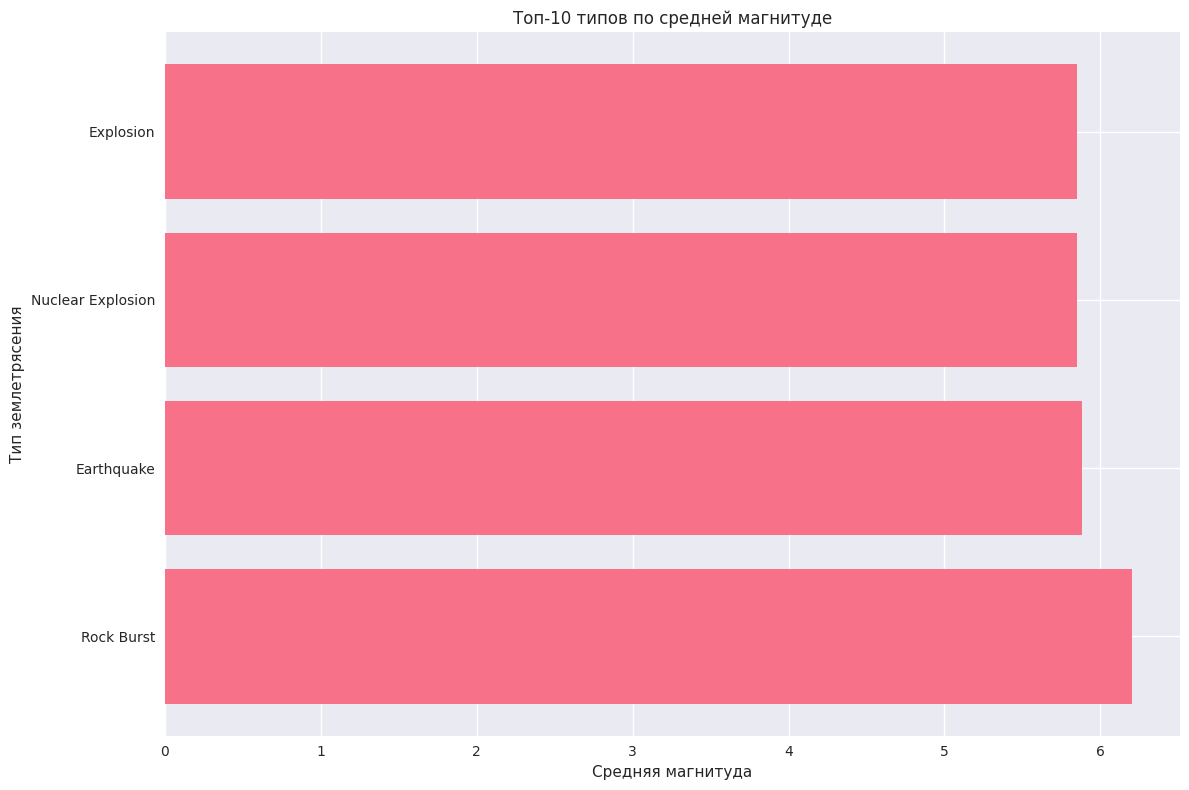

In [8]:
# График средней магнитуды по типам
plt.figure(figsize=(12, 8))
top_10 = magnitude_by_type.head(10)
plt.barh(top_10['Type'], top_10['Mean_Magnitude'])
plt.xlabel('Средняя магнитуда')
plt.ylabel('Тип землетрясения')
plt.title('Топ-10 типов по средней магнитуде')
plt.tight_layout()
plt.show()


In [9]:
!pwd

/opt/notebooks


In [10]:
%pip install hdfs

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for hdfs: filename=hdfs-2.7.3-py3-none-any.whl size=34321 sha256=5dfec40d9fb21b83293ad5a6f7c012d9c702dcb957cbd05b5033ae997d27679b
  Stored in directory: /root/.cache/pip/wheels/68/dd/29/c1a590238f9ebbe4f7ee9b3583f5185d0b9577e23f05c990eb
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=53f089d73b9a63007aa02b9dcc972a5011972b5eae93f5fc9b586a49ee511773
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built hdfs docopt
Note: you may need to restart the kernel to use updated packages.


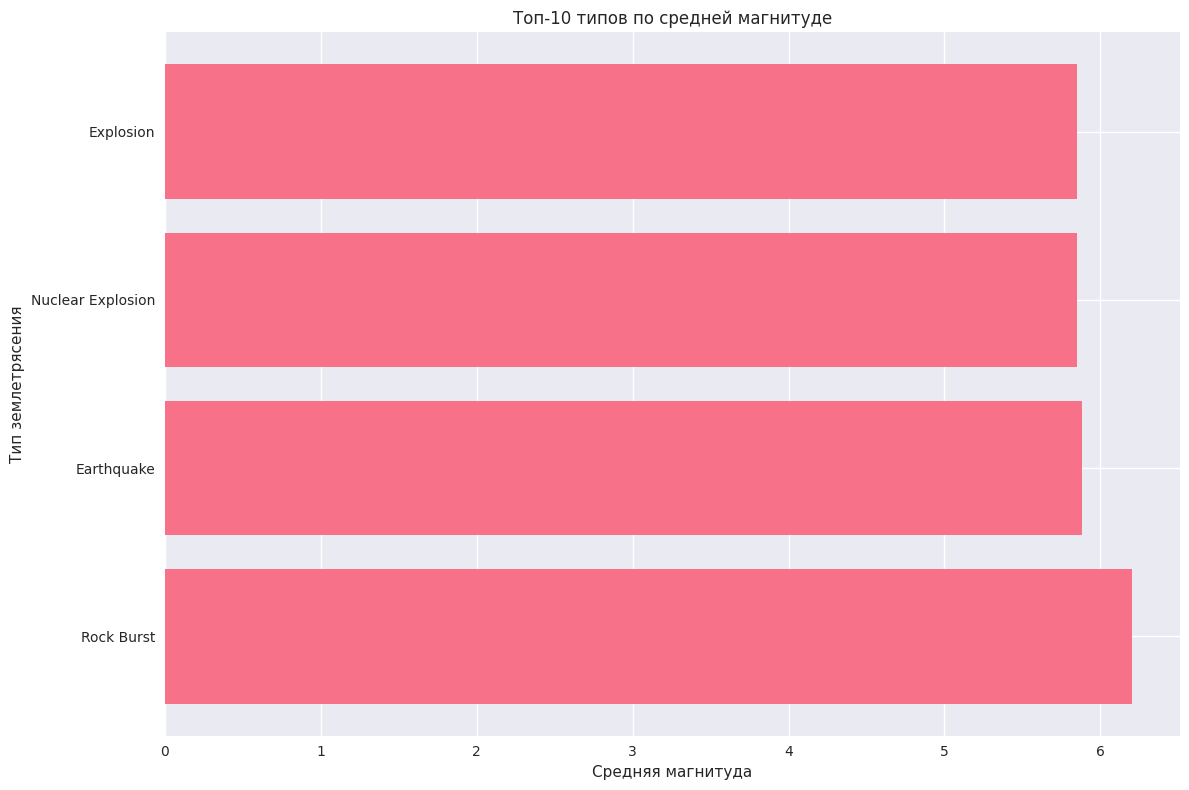

График успешно сохранен и/или перезаписан в HDFS по пути: /user/hadoop/results/magnitude_by_type.png
Found 1 items
-rw-r--r--   1 root supergroup     104950 2025-10-29 07:19 /user/hadoop/results/magnitude_by_type.png


In [11]:
import io
import os
import matplotlib.pyplot as plt
from hdfs import InsecureClient

# --- 1. код для построения графика ---
# (Убедитесь, что переменная 'magnitude_by_type' уже существует)
plt.figure(figsize=(12, 8))
top_10 = magnitude_by_type.head(10)
plt.barh(top_10['Type'], top_10['Mean_Magnitude'])
plt.xlabel('Средняя магнитуда')
plt.ylabel('Тип землетрясения')
plt.title('Топ-10 типов по средней магнитуде')
plt.tight_layout()


# --- 2. Сохранение графика в буфер памяти ---
# Создаем "виртуальный файл" в оперативной памяти
buffer = io.BytesIO()

# Сохраняем изображение в буфер в формате PNG
plt.savefig(buffer, format='png', dpi=300)

# Показываем график в выводе ячейки, чтобы его было видно
plt.show()

# "Перематываем" курсор буфера в начало, чтобы его можно было прочитать
buffer.seek(0)


# --- 3. Подключение к HDFS и запись файла ---
# Определяем путь к файлу в HDFS
hdfs_path = '/user/hadoop/results/magnitude_by_type.png'
hdfs_dir = os.path.dirname(hdfs_path)

# Подключаемся к HDFS NameNode (hadoop - имя контейнера, 9870 - порт web-интерфейса)
client = InsecureClient('http://hadoop:9870', user='root')

# Создаем директорию, если она вдруг отсутствует
client.makedirs(hdfs_dir)

# Записываем данные из буфера в HDFS, перезаписывая файл, если он существует
with client.write(hdfs_path, overwrite=True) as writer:
    writer.write(buffer.getvalue())

print(f"График успешно сохранен и/или перезаписан в HDFS по пути: {hdfs_path}")


# --- 4. Проверка результата ---
# Выводим содержимое директории в HDFS, чтобы убедиться, что файл на месте
!hdfs dfs -ls /user/hadoop/results

/tmp/ipykernel_1338/2341163698.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


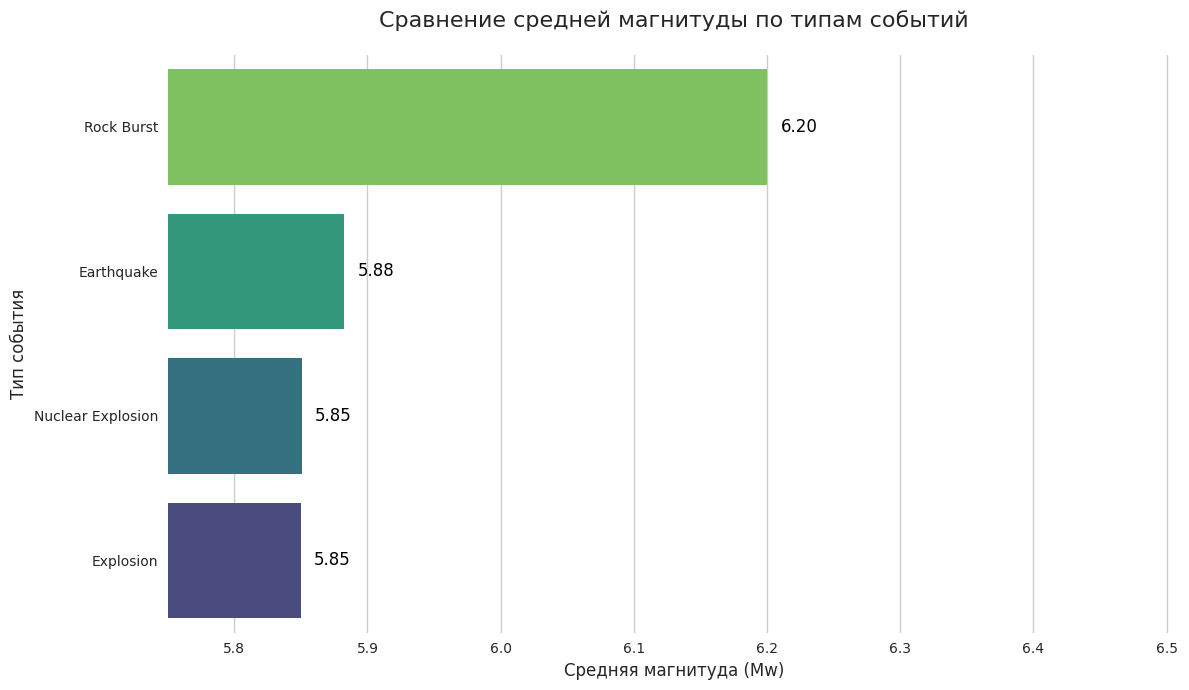

График успешно перезаписан в HDFS по пути: /user/hadoop/results/magnitude_by_type.png
Found 1 items
-rw-r--r--   1 root supergroup     130672 2025-10-29 07:19 /user/hadoop/results/magnitude_by_type.png


In [12]:
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from hdfs import InsecureClient

# --- Убедитесь, что библиотека установлена ---
# Если вы перезапускали ядро, возможно, потребуется снова выполнить:
# %pip install hdfs

# --- 1. Подготовка данных и сортировка ---
# Предполагается, что у вас уже есть DataFrame 'magnitude_by_type'
# Сортируем данные для наглядности
df_sorted = magnitude_by_type.sort_values('Mean_Magnitude', ascending=False)


# --- 2. Создание улучшенного графика ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))

ax = sns.barplot(
    x='Mean_Magnitude',
    y='Type',
    data=df_sorted,
    palette='viridis_r'
)

# "Приближаем" ось X для акцентирования разницы
min_val = df_sorted['Mean_Magnitude'].min()
plt.xlim(left=min_val - 0.1)

# Добавляем метки со значениями
for bar in ax.patches:
    ax.text(
        bar.get_width() + 0.01,
        bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.2f}',
        va='center', ha='left',
        fontsize=12, color='black'
    )

# Настройка заголовков и осей
plt.title('Сравнение средней магнитуды по типам событий', fontsize=16, pad=20)
plt.xlabel('Средняя магнитуда (Mw)', fontsize=12)
plt.ylabel('Тип события', fontsize=12)
sns.despine(left=True, bottom=True)
plt.tight_layout()


# --- 3. Сохранение графика в буфер памяти ---
buffer = io.BytesIO()
plt.savefig(buffer, format='png', dpi=300)
# Показываем график в ноутбуке
plt.show()
# "Перематываем" буфер в начало для чтения
buffer.seek(0)


# --- 4. Подключение к HDFS и перезапись файла ---
hdfs_path = '/user/hadoop/results/magnitude_by_type.png'

# Подключаемся к HDFS
client = InsecureClient('http://hadoop:9870', user='root')

# Записываем данные из буфера в HDFS с флагом перезаписи
with client.write(hdfs_path, overwrite=True) as writer:
    writer.write(buffer.getvalue())

print(f"График успешно перезаписан в HDFS по пути: {hdfs_path}")


# --- 5. Проверка результата ---
!hdfs dfs -ls /user/hadoop/results